# Case study: Samusik bone marrow CyTOF data

This notebook generates results for a case study that uses a [mass cytometry (CyTOF) mouse bone marrow dataset](https://pubmed.ncbi.nlm.nih.gov/27183440/).

This is to illustrate integration with FlowSOM and how the MST topology can be verified using ViVAE embeddings.
Essentially, automated clustering and dimensionality reduction are independent methods of exploratory modelling, and this allows to detect potential discrepancies between them.

<hr>

## **0.** Load required modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.patches import Circle, Wedge

os.environ['VIVAE_DETERMINISTIC'] = '1'
os.environ['VIVAE_CUDA'] = '0'
os.environ['VIVAE_MPS'] = '0'

import vivae as vv
import torch
import flowsom as fs

INFO:vivae:initialised with "cpu" backend and determinism enabled


## **1.** Load input data

In [6]:
dataset = 'Samusik'

ff       = fs.io.read_FCS(os.path.join('..', 'cytometry_data', f'{dataset}.fcs'))
col_idcs = np.arange(8, 47) # column indices of markers of interest
ff       = ff[:,col_idcs]
cofactor = 5.
for channel in range(ff.shape[1]):
    ff[:,channel].X = np.arcsinh(ff[:,channel].X/cofactor)
exprs   = np.asarray(ff.X) # extracted expression data

labels   = np.load(os.path.join('..', 'cytometry_data', f'{dataset}_annot.npy'), allow_pickle=True)

knn     = vv.make_knn(x=exprs, fname=os.path.join('..', 'cytometry_data', f'{dataset}_knn.npy'), random_state=1) # already exists, load
exprs_d = vv.smooth(exprs, knn, k=100, coef=1., n_iter=1)

Loading k-NNG


## **2.** Generate embedding

In [3]:
np.random.seed(1)
torch.manual_seed(1)

model_vivae = vv.ViVAE(input_dim=exprs.shape[1], latent_dim=2, random_state=1)
model_vivae.fit(exprs_d, n_epochs=50, batch_size=1024, lam_recon=1., lam_kldiv=1., lam_mds=10.)

emb_vivae = model_vivae.transform(exprs_d)

Epoch 1/50	recon: 74.0053	kldiv: 0.5907	geom: 0.0000	egeom: 0.0000	mds: 104.0331	imit: 0.0000
Epoch 2/50	recon: 15.0172	kldiv: 0.4936	geom: 0.0000	egeom: 0.0000	mds: 26.2921	imit: 0.0000
Epoch 3/50	recon: 7.2430	kldiv: 0.4422	geom: 0.0000	egeom: 0.0000	mds: 12.9902	imit: 0.0000
Epoch 4/50	recon: 3.5571	kldiv: 0.3569	geom: 0.0000	egeom: 0.0000	mds: 6.3108	imit: 0.0000
Epoch 5/50	recon: 2.2345	kldiv: 0.2493	geom: 0.0000	egeom: 0.0000	mds: 4.8078	imit: 0.0000
Epoch 6/50	recon: 1.6317	kldiv: 0.1985	geom: 0.0000	egeom: 0.0000	mds: 3.9131	imit: 0.0000
Epoch 7/50	recon: 1.2383	kldiv: 0.1633	geom: 0.0000	egeom: 0.0000	mds: 3.3439	imit: 0.0000
Epoch 8/50	recon: 0.9843	kldiv: 0.1383	geom: 0.0000	egeom: 0.0000	mds: 2.9041	imit: 0.0000
Epoch 9/50	recon: 0.8234	kldiv: 0.1205	geom: 0.0000	egeom: 0.0000	mds: 2.5986	imit: 0.0000
Epoch 10/50	recon: 0.7006	kldiv: 0.1063	geom: 0.0000	egeom: 0.0000	mds: 2.3156	imit: 0.0000
Epoch 11/50	recon: 0.6072	kldiv: 0.0943	geom: 0.0000	egeom: 0.0000	mds: 2.0703	imit

## **3.** Train FlowSOM model

In [4]:
fsom = fs.FlowSOM(ff, n_clusters=40, xdim=10, ydim=10, seed=1)

2025-04-29 21:17:20.381 | DEBUG    | flowsom.main:__init__:82 - Reading input.
2025-04-29 21:17:20.411 | DEBUG    | flowsom.main:__init__:84 - Fitting model: clustering and metaclustering.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-04-29 21:17:24.549 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.


## **4.** Plot embedding without and with FlowSOM tree overlay

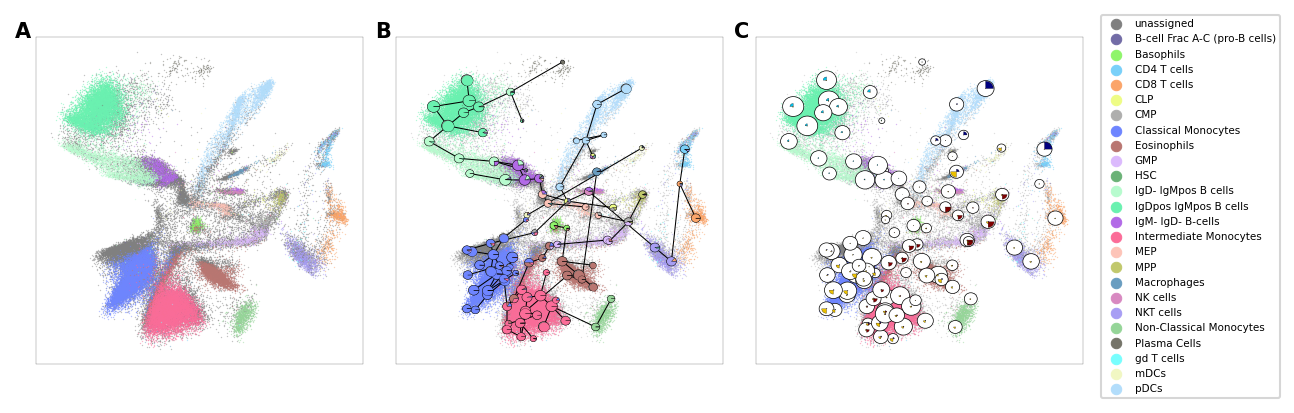

In [ ]:
palette = ['#726ca6','#8ff56b','#79d0f9','#fba56a','#eefc85','#aeaead','#6e85ff','#b97671','#dbbafd','#6bb277','#b7fbce','#6af1b0','#b26ae7','#fb6c98','#fdc4b8','#c1c86c','#699dc0','#d889c1','#a89ef4','#95d598','#757469','#78fefe','#f1f7c3','#b2ddfb','#cad9a3','#9b9f69','#aa7caa','#74c7c0','#face7e','#fe9cdb','#ce9f81','#bafc85','#fdd5f1','#e97f6c','#8d89d7','#839095','#d68ef9','#a5d1ca','#d1fcfe','#6eaaee','#f799a1','#d7b2c8','#70d87a','#99faa9','#6b70d4','#dbd8d2','#fb77c9','#88f4d2','#d17a98','#90b2d3','#aafef7','#debc9d','#d2e96a','#96c96a','#8c6ff5','#927286','#7cff8e','#80b19e','#adbcfa','#d86fdd','#aee276','#eee1a5','#feb6fe','#996dc9','#b699cc','#ad908d','#76946b','#d2fea8','#a7b883','#b881fe','#69e7da','#92e8f5','#b5b6d4','#dadcfa','#bf6cbe','#9199b6','#70d79f','#6afd6e','#dcb26c','#d69fae','#b5eab1','#fce96a','#6987aa','#8dadfc','#938afd','#c7ebe4','#de6a7f','#938669','#c4cce8','#e36daf','#e8f1e8','#86e1b6','#ff6b69','#ed9ffc','#87d7d6','#feb58d','#b96a93','#dcd189','#adc9a7']
mpl.rcParams['axes.linewidth'] = 0.1
pops = np.unique(labels)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), dpi=150, sharey=True)
fig.subplots_adjust(wspace=.1)
s = .01
idcs_unass = np.where(labels=='unassigned')[0]

## Plot points

ax[0].scatter(emb_vivae[idcs_unass,0], emb_vivae[idcs_unass,1], s=s, label='unassigned', c='grey', alpha=1., linewidth=.5)
ax[1].scatter(emb_vivae[idcs_unass,0], emb_vivae[idcs_unass,1], s=s,                     c='grey', alpha=.5, linewidth=.5)
ax[2].scatter(emb_vivae[idcs_unass,0], emb_vivae[idcs_unass,1], s=s,                     c='grey', alpha=.5, linewidth=.5)

for i, pop in enumerate(pops):
    if pop!='unassigned':
        idcs = np.where(labels==pop)[0]
        ax[0].scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=s, label=pop, c=palette[i], alpha=1., linewidth=.5)
        ax[1].scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=s,            c=palette[i], alpha=1., linewidth=.5)
        ax[2].scatter(emb_vivae[idcs,0], emb_vivae[idcs,1], s=s,            c=palette[i], alpha=1., linewidth=.5)

l = fig.legend(bbox_to_anchor=(1.05, .92), fontsize=5, markerscale=50.)

fsom_node_scale = 0.004
fsom_edge_scale = 0.5

## Plot FlowSOM tree with metacluster compositions

cluster_sizes = fsom.get_cluster_data().obs['percentages']
cluster_empty = cluster_sizes==0.
ranges = np.ptp(emb_vivae, axis=0)
maxsize = np.min(ranges)*fsom_node_scale
node_sizes = np.sqrt(np.multiply((np.divide(cluster_sizes, np.max(cluster_sizes))), maxsize))
node_sizes[cluster_empty] = min([0.05, node_sizes.max()])
centroids = fsom.get_cluster_data().obsm['codes']
layout = model_vivae.transform(centroids)
edge_list = fsom.get_cluster_data().uns['graph'].get_edgelist()
segment_plot = [
    (layout[nodeID[0], 0],
        layout[nodeID[0], 1],
        layout[nodeID[1], 0],
        layout[nodeID[1], 1])
        for nodeID in edge_list
]
edges = np.asarray(segment_plot, dtype=np.float32)
e = [[(row[0], row[1]), (row[2], row[3])] for row in edges]
mst = mc.LineCollection(e)
mst.set_edgecolor('black')
mst.set_linewidth(fsom_edge_scale)
ax[1].add_collection(mst)
nodes = [Circle((row[0], row[1]), node_sizes.iloc[i]) for i, row in enumerate(layout)]
n = mc.PatchCollection(nodes)
n.set_facecolor(['#C7C7C7' if tf else '#FFFFFF' for tf in cluster_empty])
n.set_edgecolor('black')
n.set_linewidth(fsom_edge_scale/1.5)
n.set_zorder(3)
ax[1].add_collection(n)
pops = np.unique(labels)
color_dict = dict(zip(pops, palette))
color_dict['unassigned'] = '#bfbfbf'
for cl in range(fsom.get_cell_data().uns['n_nodes']):
    node_cell_types = labels[fsom.get_cell_data().obs['clustering'] == cl]
    node_cell_types = node_cell_types[[x not in ['unassigned'] for x in node_cell_types]]
    if len(node_cell_types) != 0:
        table = pd.crosstab(node_cell_types, columns='count')
        table['part'] = np.multiply(np.divide(table['count'], sum(table['count'])), 360)
        angles = np.asarray(np.cumsum(table['part']))
        if 0 not in angles:
            angles = np.insert(angles, 0, 0)
        row = layout[cl, :]
        patches = fs.pl._plot_helper_functions.add_wedges(
            tuple(row), heights=np.repeat(node_sizes.iloc[cl], len(angles)), angles=angles
        )
        p = mc.PatchCollection(patches)
        p.set_facecolor([color_dict.get(key) for key in table.index.values])
        p.set_edgecolor('black')
        p.set_linewidth(fsom_edge_scale/4.)
        p.set_zorder(3)
        ax[1].add_collection(p)

## Plot FlowSOM tree with marker expression

fsom_markers = ['CD4', 'CD19', 'CD64', 'cKit']
fsom_node_scale = 0.012

cluster_sizes = fsom.get_cluster_data().obs['percentages']
cluster_empty = cluster_sizes==0.
ranges = np.ptp(emb_vivae, axis=0)
maxsize = np.min(ranges)*fsom_node_scale
node_sizes = np.sqrt(np.multiply((np.divide(cluster_sizes, np.max(cluster_sizes))), maxsize))
node_sizes[cluster_empty] = min([0.05, node_sizes.max()])
nodes = [Circle((row[0], row[1]), node_sizes.iloc[i]) for i, row in enumerate(layout)]

cmap = fs.pl._plot_helper_functions.FlowSOM_colors()
n = mc.PatchCollection(nodes, cmap=cmap)
n.set_facecolor(['#C7C7C7' if tf else '#FFFFFF' for tf in cluster_empty])
n.set_edgecolor('black')
n.set_linewidth(fsom_edge_scale/1.5)
n.set_zorder(3)
ax[2].add_collection(n)
var_names = fsom.get_cell_data().var_names
marker_table = fsom.get_cell_data().var['marker']
markers = []
for i, m in enumerate(fsom_markers):
    if m not in var_names:
        idx = marker_table[marker_table==m].index
        if len(idx)!=1:
            raise ValueError(f'Marker {m} cannot be matched to a FlowSOM channel')
        markers.append(idx[0])
    else:
        markers.append(m)
markers = np.asarray(markers)
pretty_markers = fsom.get_cell_data()[:, markers].var['pretty_colnames']
max_x, max_y = np.max(layout, axis=0)

data = fsom.get_cluster_data()[:, markers].X
heights = fs.pl._plot_helper_functions.scale_star_heights(data, node_sizes)
s = mc.PatchCollection(fs.pl._plot_helper_functions.add_stars(layout, heights), cmap=cmap)

s.set_array(range(data.shape[1]))
s.set_edgecolor('black')
s.set_linewidth(fsom_edge_scale/4.)
s.set_zorder(3)
ax[2].add_collection(s)

## Axes and labels

ax[0].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax[1].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax[2].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)

ax[0].set_title('A', size=10, ha='left', x=-.065, y=.96, fontweight='bold')
ax[1].set_title('B', size=10, ha='left', x=-.065, y=.96, fontweight='bold')
ax[2].set_title('C', size=10, ha='left', x=-.065, y=.96, fontweight='bold')

fig.savefig('samusik_flowsom.png', bbox_inches='tight', dpi=600, transparent=True)
fig.savefig('samusik_flowsom.svg', bbox_inches='tight', transparent=True)